# Weather simulation

Based on Steve Brunton's ["Gentle introduction to modelling with matrices and vectors"](https://www.youtube.com/watch?v=K-8F_zDMDUI&t=277s) although my code is my own. Use if you want to for whatever purpose, but it's trivial so if you're trying to learn, you will learn much more by doing it yourself so you get a handle on how to beat numpy into submission etc. For simplicity I use the same naming $\mathbf{A}$ and $\mathbf{x}$ and the same ordering of the states as Steve does.

## Purpose of the model

The model is intended to retreive the probability of the weather being in one of 3 states ("rainy", "cloudy", or "nice") on a given day. It is intended as an educational example to show how to build a basic probabilistic model using matrices in python. 

## Spec
The basis of the model is a state transition matrix $\mathbf{A}$ which, given a state today, gives the probabilities of transition to all the possible states tomorrow.  

In this model, weather can have 3 states, "rainy", "nice" or "cloudy", and the state transition probabilities are given by $$\mathbf{A} = \begin{pmatrix} 0.5 & 0.5 & 0.25\\ 0.25 & 0 & 0.25\\ 0.25 & 0.5 & 0.5 \end{pmatrix}$$

On day $t$, the probability of weather tomorrow is $\mathbf{x}_{t+1} = \mathbf{A} \cdot \mathbf{x}_t$. Probabalistic models of this type are known as [Markov State Models](https://pmc.ncbi.nlm.nih.gov/articles/PMC2933958/) or _MSMs_.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# States are rainy, nice or cloudy.
# State transitions are as follows
A= np.array([
    [0.5, 0.5, 0.25],
    [0.25, 0, 0.25],
    [0.25, 0.5, 0.5]
    ])

# inital state is known - put a 1 in whatever column you like and confirm it will
# converge to the same steady-state probability distribution anyway.
initial = np.array([1,0,0])

#run the simulation for n days
n=25
x=np.zeros((3,n+1))

# notice funky syntax for indexing by column as a column vector.
# v[:,i] means 'the i-th column of v as an array'
# v[:, [i]] means 'the i-th column of v as a column vector'
# The slice "[:,np.newaxis]" is to get it to actually transpose to a real column vector.
# Numpy transpose will just ignore you if you just try to do 
# np.transpose(np.array([1,2,3])), which is really fucking annoying imo.
x[:,[0]]=initial[:,np.newaxis]
for t in range(n):
    tomorrow=A @ x[:,[t]]
    print(f"t={t:2d}: tomorrow: {np.transpose(tomorrow)[0]}")
    x[:,[t+1]] = tomorrow

t= 0: tomorrow: [0.5  0.25 0.25]
t= 1: tomorrow: [0.4375 0.1875 0.375 ]
t= 2: tomorrow: [0.40625  0.203125 0.390625]
t= 3: tomorrow: [0.40234375 0.19921875 0.3984375 ]
t= 4: tomorrow: [0.40039062 0.20019531 0.39941406]
t= 5: tomorrow: [0.40014648 0.19995117 0.39990234]
t= 6: tomorrow: [0.40002441 0.20001221 0.39996338]
t= 7: tomorrow: [0.40000916 0.19999695 0.3999939 ]
t= 8: tomorrow: [0.40000153 0.20000076 0.39999771]
t= 9: tomorrow: [0.40000057 0.19999981 0.39999962]
t=10: tomorrow: [0.4000001  0.20000005 0.39999986]
t=11: tomorrow: [0.40000004 0.19999999 0.39999998]
t=12: tomorrow: [0.40000001 0.2        0.39999999]
t=13: tomorrow: [0.4 0.2 0.4]
t=14: tomorrow: [0.4 0.2 0.4]
t=15: tomorrow: [0.4 0.2 0.4]
t=16: tomorrow: [0.4 0.2 0.4]
t=17: tomorrow: [0.4 0.2 0.4]
t=18: tomorrow: [0.4 0.2 0.4]
t=19: tomorrow: [0.4 0.2 0.4]
t=20: tomorrow: [0.4 0.2 0.4]
t=21: tomorrow: [0.4 0.2 0.4]
t=22: tomorrow: [0.4 0.2 0.4]
t=23: tomorrow: [0.4 0.2 0.4]
t=24: tomorrow: [0.4 0.2 0.4]


As you can see, this converges rapidly to a steady state probability distribution $p = \begin{pmatrix} 0.4 & 0.2 & 0,4\end{pmatrix}^T$ which is apparently a property of all Markov state transition models - that they converge to a steady state where the state transition probability is the eigenvector of $\mathbf{A}$ corresponding to the eigenvalue of 1.  Let's confirm that

In [2]:
eig=np.linalg.eig(A)
eig.eigenvalues

array([ 1.  ,  0.25, -0.25])

get the first column of the matrix "eig.eigenvectors" which is the eigenvector corresponding to $\lambda = 1$.

In [3]:
eig.eigenvectors[:,0]

array([-0.66666667, -0.33333333, -0.66666667])

That doesn't look like our steady state probability, and in fact doesn't look like a probability at all given it doesn't sum to 1. That's because numpy gives normalised eigenvectors (ie for $\mathbf{Av}=\lambda\mathbf{v}$ it actually returns $\widehat{\mathbf{v}}=\frac{\mathbf{v}}{|\mathbf{v}|}$). This is obviously normally quite useful but in this specific case not so much.

Steve explains how to deal with this in the matlab portion of the video. We need to normalise by dividing by the sum of the elements in the vector. Since we know that if $\mathbf{v}$ is an eigenvector of $\mathbf{A}$, then any vector $\mathbf{w}=\alpha\mathbf{v}$ scaled by some scalar $\alpha$ is also an eigenvector of $\mathbf{A}$ corresponding to the same eigenvalue, clearly this will yield another eigenvector in the same direction as the $\mathbf{v}$ but with the helpful additional property that it looks like a probability distribution because
$$\sum_{k=1}^n w_k = 1$$

In the case where the components had mixed signs we would need to do something else because probabilities also need to be non-negative, but that isn't a problem here.

In [4]:
def normalise(r):
    return r/np.sum(r)
    
normalise(eig.eigenvectors[:,0])

array([0.4, 0.2, 0.4])

Cool beans.

Here's how we make a quick and dirty plot showing the convergence. Notice that once they converge, since two of the lines are on top of each other you can't see all three clearly. You could make one wider and the other somewhat transparent to fix this issue, but I can't be bothered.

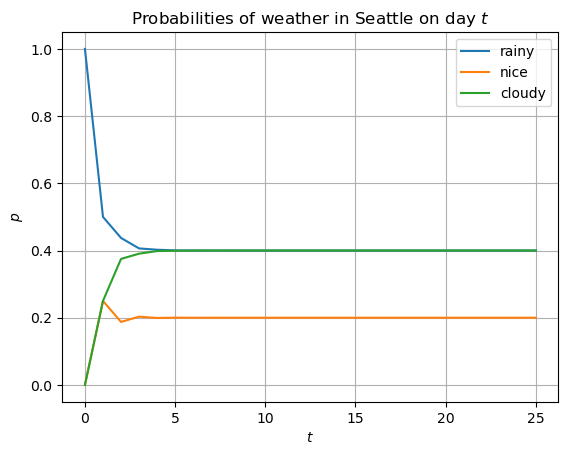

In [5]:
fig_, ax = plt.subplots()
plt.plot(np.transpose(x))
plt.grid(True)
plt.legend(["rainy","nice","cloudy"])
plt.title("Probabilities of weather in Seattle on day $t$")
ax.set_ylabel('$p$')
_= ax.set_xlabel("$t$")

# Running this notebook

I run this notebook on nixos with the following `flake.nix`:

```nix
{
  inputs = {
    nixpkgs = {
      url = "github:nixos/nixpkgs/nixos-unstable";
    };
    flake-utils = {
      url = "github:numtide/flake-utils";
    };
  };
  outputs = { nixpkgs, flake-utils, ... }: flake-utils.lib.eachDefaultSystem (system:
    let
      pkgs = import nixpkgs {
        inherit system;
      };
    in {
      devShell = pkgs.mkShell {
         buildInputs = with pkgs; [
          (python3.withPackages(ps: with ps; [
            ipython
            jupyter
            numpy
            matplotlib
          ]))
        ];
        shellHook = "jupyter notebook";
      };
    }
  );
}
```
...and just doing `nix develop` to give me a reproducible python notebook environment, which is pretty swell.

In general, if you just did

```bash
python -m venv .venv
source .venv/bin/activate
pip install ipython jupyter numpy matplotlib
jupyter notebook
```

...it should probably work as long as your local build environment is correctly configured, which can be a bit of a  pita with numpy frankly. If this is annoying for you, check out [conda](https://anaconda.org/anaconda/conda) which a lot of people use to give themselves a "batteries included" python notebook env without the hassle.